# Introduction

## Regression with a Tabular Media Campaign Cost Datase
- Playground Series - Season 3, Episode 11
[대회 링크](https://www.kaggle.com/competitions/playground-series-s3e11/overview)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Modules, versions ,logs , data load

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score

from sklearn.metrics import mean_squared_log_error,mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import make_scorer

import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMRegressor
%matplotlib inline

In [ ]:
import pkg_resources

# 사용된 모듈과 버전 가져오기
modules = [
    'pandas',
    'matplotlib',
    'numpy',
    'seaborn',
    'scipy',
    'scikit-learn',
    'lightgbm',
]

module_versions = {}

for module in modules:
    try:
        version = pkg_resources.get_distribution(module).version
    except pkg_resources.DistributionNotFound:
        version = 'Not Found'
    module_versions[module] = version

module_df = pd.DataFrame(module_versions.items(), columns=['Module', 'Version']).set_index('Module')
module_df

,Version
Module,
pandas,2.0.3
matplotlib,3.7.1
numpy,1.25.2
seaborn,0.13.1
scipy,1.11.4
scikit-learn,1.2.2
lightgbm,4.1.0


In [ ]:
# 실험 로그 데이터프레임 생성
exp_log = [
    ['2024-04-20', '피처 요약표 최초 작성, 인코딩 전략 수립',                   'LR', 0.31736 ],
    ['2024-04-21', 'EDA 통한 데이터셋 파악, 1차 베이스라인 생성',               'Rf',0.30937 ],
    ['2024-04-22', '데이터 인코딩 수행, 파이프라인&교차검증&AutoML 구축 시도',  'CB', 0.29860],
    ['2024-04-23', 'XGB+Gridsearch+KFold 사용 및 최적 파라미터 추출 과정',      'XGB', 0.29521],
    ['2024-04-24', '파라미터 고도화, 파생변수 생성에 따른 성능 향상',           'LGBM', 0.29346 ],

]

progress = pd.DataFrame(exp_log, columns=['date', 'task', 'model', 'AUC_score'])

# datetime 형식으로 변환
progress['date'] = pd.to_datetime(progress['date'])

# Gantt 차트를 위한 데이터프레임 생성
gantt_data = pd.DataFrame({
    'Task': progress['task'],
    'Start': progress['date'],
    'Finish': progress['date'] + pd.to_timedelta('1 days'), # 작업은 하루 동안 진행됨
    'AUC Score': progress['AUC_score']
})

# Gantt 차트 생성
fig = px.timeline(gantt_data, x_start='Start', x_end='Finish', y='Task', title='Project Progress',
                  labels={'Task': 'Task', 'Start': 'Start Date', 'Finish': 'End Date', 'AUC Score': 'AUC Score'})

# AUC 스코어 텍스트 표시
fig.add_trace(go.Scatter(
    x=gantt_data['Start'] + (gantt_data['Finish'] - gantt_data['Start']) / 2,
    y=gantt_data['Task'],
    text=gantt_data['AUC Score'].map('{:.5f}'.format),
    textposition='middle center',
    textfont=dict(color='white', family='bold',size=16),
    mode='text'
))

# 시각화
fig.update_yaxes(categoryorder='total ascending') # 작업 순서 지정
fig.show()

In [ ]:
# 알고리즘 구동 일지
exp_log = [
    ['2022-04-20', 'LR', '-', '-', 0.31736, '-'],
    ['2022-04-20', 'RF', 'n_estimators = 100,max_depth=5,n_jobs=-1,', '기본형 수행',  0.30937, '-'],
    ['2022-04-22', 'Catboost', '-','기본형수행',  0.29860, '-'],
    ['2022-04-23', 'XGB+Gridsearch', 'learning_rate=0.05,n_estimators=1000-1500,min_child_weight=2-3','범위를 넓혀 수행',  0.29521, '-'],
    ['2022-04-23', 'XGB+KFold', 'learning_rate=0.05,n_estimators=2000,max_depth=5','최종 KFold값 하락',  0.29521, '-'],
    ['2022-04-23', 'XGB', 'learning_rate=0.05,n_estimators=2000,max_depth=5','하이퍼파라미터값 부여',  0.29494, 0.29518],
    ['2022-04-24', 'LGBM', '-','기본형 수행',  0.29819,'-'],
    ['2022-04-24', 'LGBM', 'KFold/ n_splits = 10','kfold 수행',  0.29309,0.29359],
    ['2022-04-24', 'LGBM', 'max_depth = 9,num_leaves=100,n_estimators=2000','하이퍼파라미터 부여',0.29320,0.29346],

]

progress = pd.DataFrame(exp_log, columns=['date', 'model', 'params', 'notes', 'RMSLE', 'submission'])
progress.set_index('date', inplace=True)  # Set 'date' column as index
display(progress)

,model,params,notes,RMSLE,submission
date,,,,,
2022-04-20,LR,-,-,0.31736,-
2022-04-20,RF,"n_estimators = 100,max_depth=5,n_jobs=-1,",기본형 수행,0.30937,-
2022-04-22,Catboost,-,기본형수행,0.29860,-
2022-04-23,XGB+Gridsearch,"learning_rate=0.05,n_estimators=1000-1500,min_...",범위를 넓혀 수행,0.29521,-
2022-04-23,XGB+KFold,"learning_rate=0.05,n_estimators=2000,max_depth=5",최종 KFold값 하락,0.29521,-
2022-04-23,XGB,"learning_rate=0.05,n_estimators=2000,max_depth=5",하이퍼파라미터값 부여,0.29494,0.29518
2022-04-24,LGBM,-,기본형 수행,0.29819,-
2022-04-24,LGBM,KFold/ n_splits = 10,kfold 수행,0.29309,0.29359
2022-04-24,LGBM,"max_depth = 9,num_leaves=100,n_estimators=2000",하이퍼파라미터 부여,0.29320,0.29346


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Finalproject_1조/Final_project/2차_회귀_코드/train.csv',index_col='id')
test = pd.read_csv('/content/drive/MyDrive/Finalproject_1조/Final_project/2차_회귀_코드/test.csv', index_col='id')
submission = pd.read_csv('/content/drive/MyDrive/Finalproject_1조/Final_project/2차_회귀_코드/sample_submission.csv')
original = pd.read_csv('/content/drive/MyDrive/Finalproject_1조/Final_project/2차_회귀_코드/original.csv')


In [ ]:
train.shape,test.shape,submission.shape, original.shape

((360336, 16), (240224, 15), (240224, 2), (51363, 16))

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    360336 non-null  float64
 1   unit_sales(in millions)     360336 non-null  float64
 2   total_children              360336 non-null  float64
 3   num_children_at_home        360336 non-null  float64
 4   avg_cars_at home(approx).1  360336 non-null  float64
 5   gross_weight                360336 non-null  float64
 6   recyclable_package          360336 non-null  float64
 7   low_fat                     360336 non-null  float64
 8   units_per_case              360336 non-null  float64
 9   store_sqft                  360336 non-null  float64
 10  coffee_bar                  360336 non-null  float64
 11  video_store                 360336 non-null  float64
 12  salad_bar                   360336 non-null  float64
 13  prepared_food      

(None, None)

## EDA

- The most crucial graphs were utilized

### Histogram

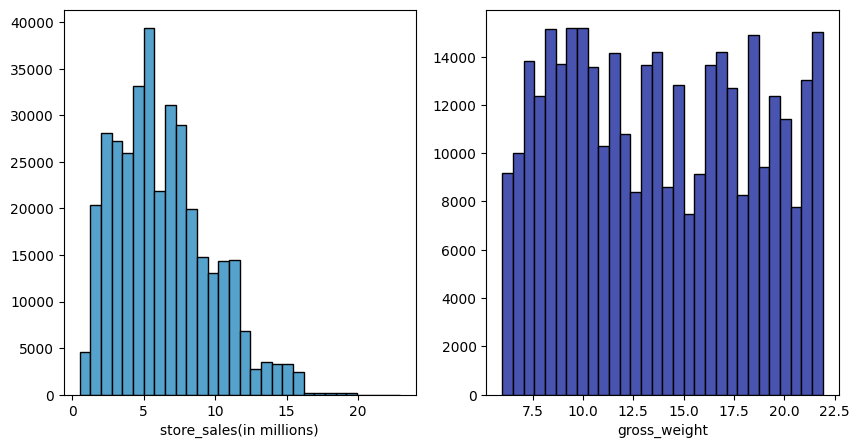

In [ ]:
num_high_list= ['store_sales(in millions)', 'gross_weight']
palette = sns.color_palette(palette='icefire', n_colors=6)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, feature in enumerate(num_high_list):
    axes[i].hist(train[feature], bins=30, edgecolor='black', color=palette[i])
    axes[i].set_xlabel(feature)
plt.show()

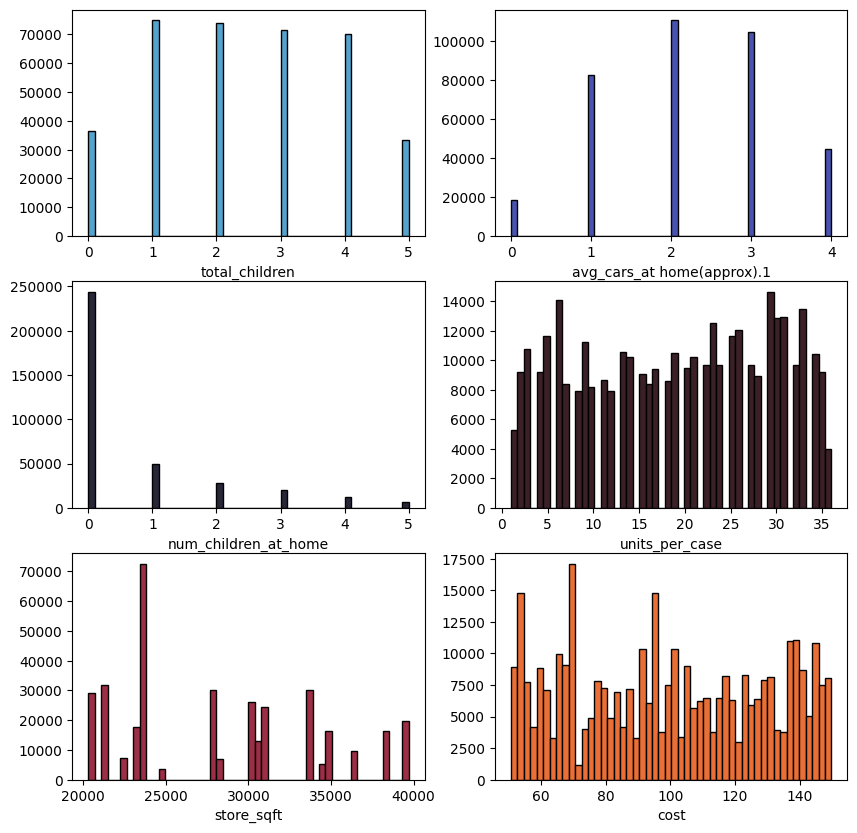

In [ ]:
num_low_list= ['total_children', 'avg_cars_at home(approx).1', 'num_children_at_home', 'units_per_case', 'store_sqft', 'cost']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
for i, feature in enumerate(num_low_list):
    axes[i//2, i%2].hist(train[feature], bins=50, edgecolor='black', color=palette[i])
    axes[i//2, i%2].set_xlabel(feature)
plt.show()

### kdeplot

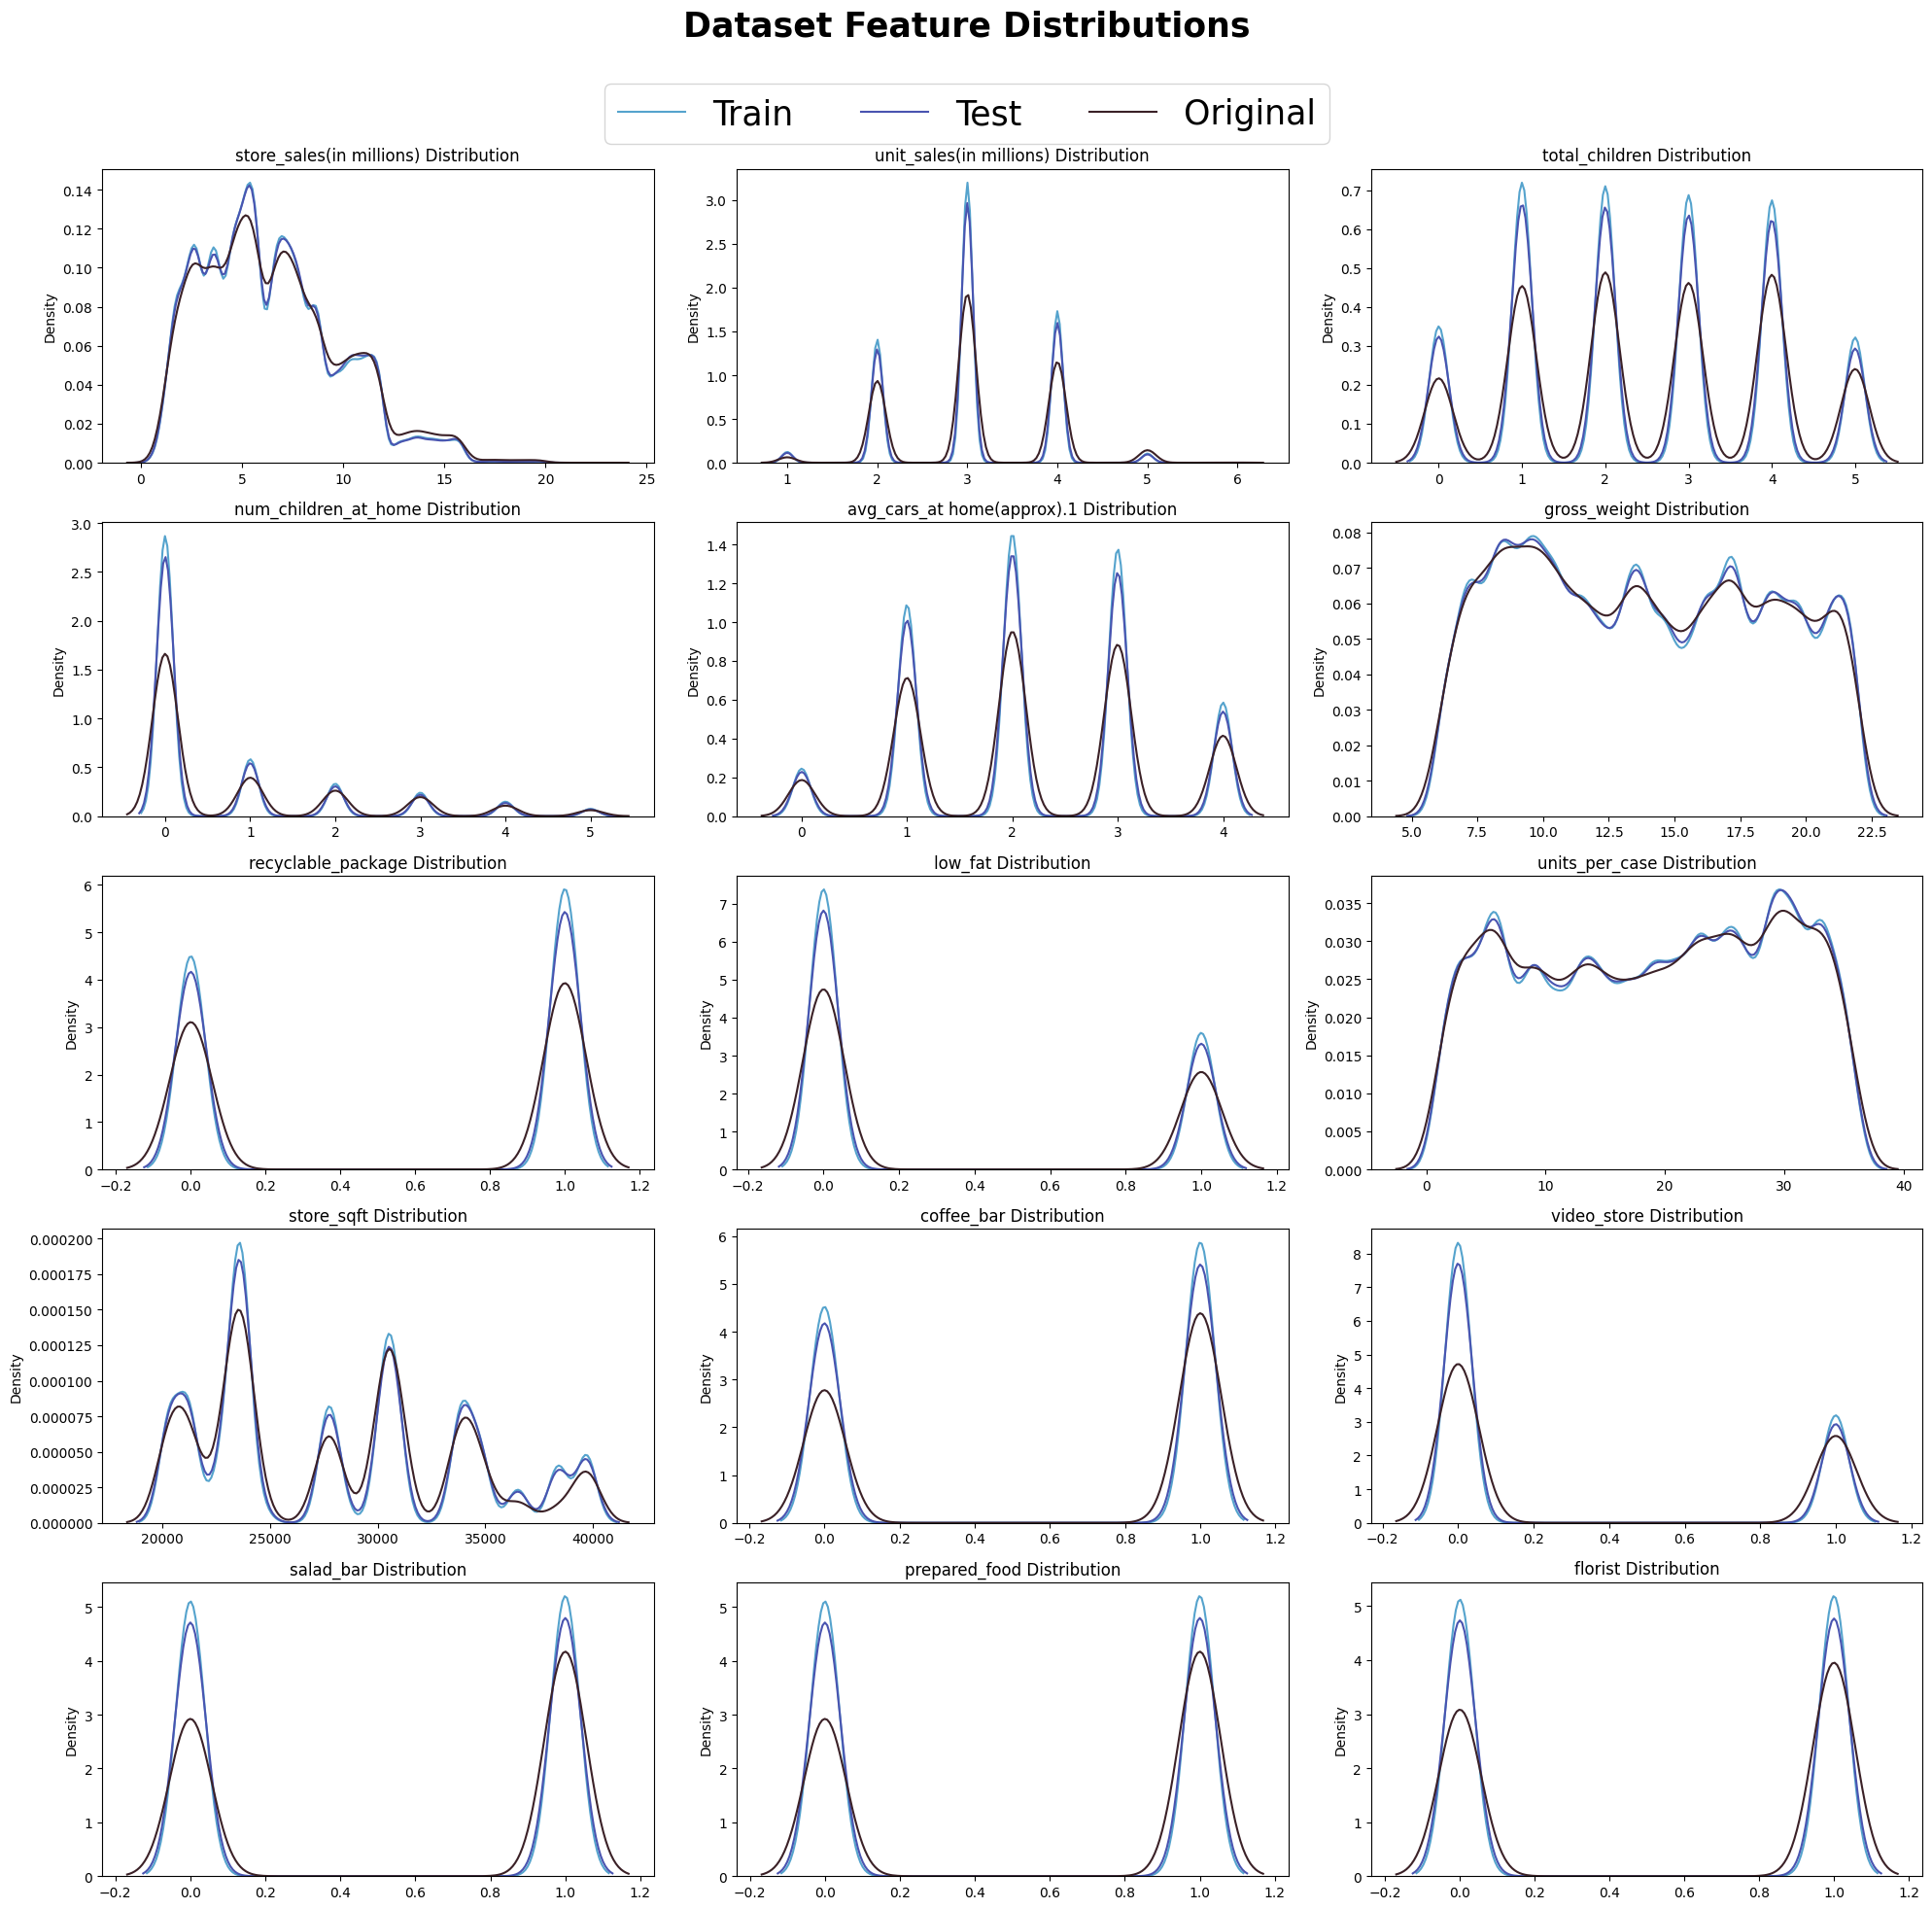

In [ ]:
feats = test.columns
n_bins = 50
histplot_hyperparams = {'kde':True, 'alpha':0.4, 'stat':'percent', 'bins':n_bins }

cols= feats
n_cols = 3
n_rows = math.ceil(len(cols)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(cols):
    plot_axes = [ax[i]]
    sns.kdeplot( train[column], label='Train',
        ax=ax[i], color=palette[0]    )

    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color=palette[1]    )

    sns.kdeplot(
        original[column], label='Original',
        ax=ax[i], color=palette[3]    )

    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)

    # 한꺼번에 보여주기
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()

for i in range(i+1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=25, ncol=3)
plt.tight_layout()

### Correlation analysis

<Axes: >

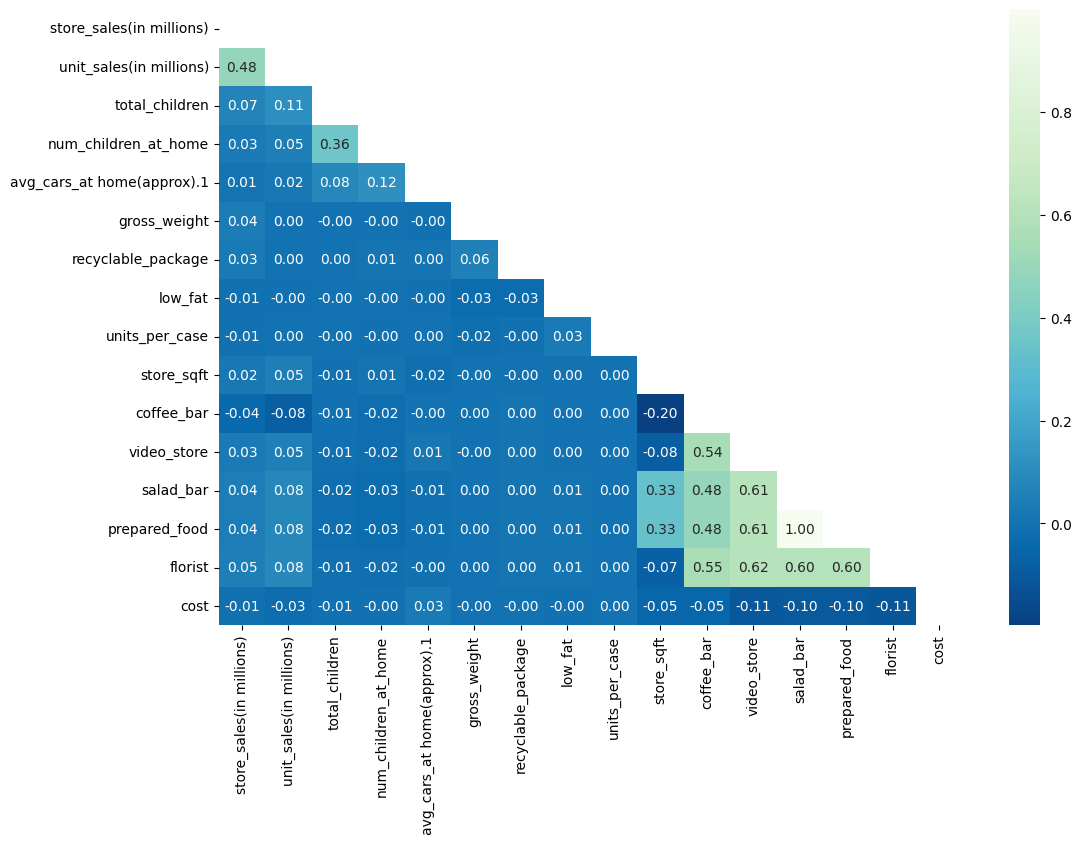

In [ ]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(), mask=mask, annot=True, fmt='.2f', cmap='GnBu_r')

### Constructed variable - 'store_score'

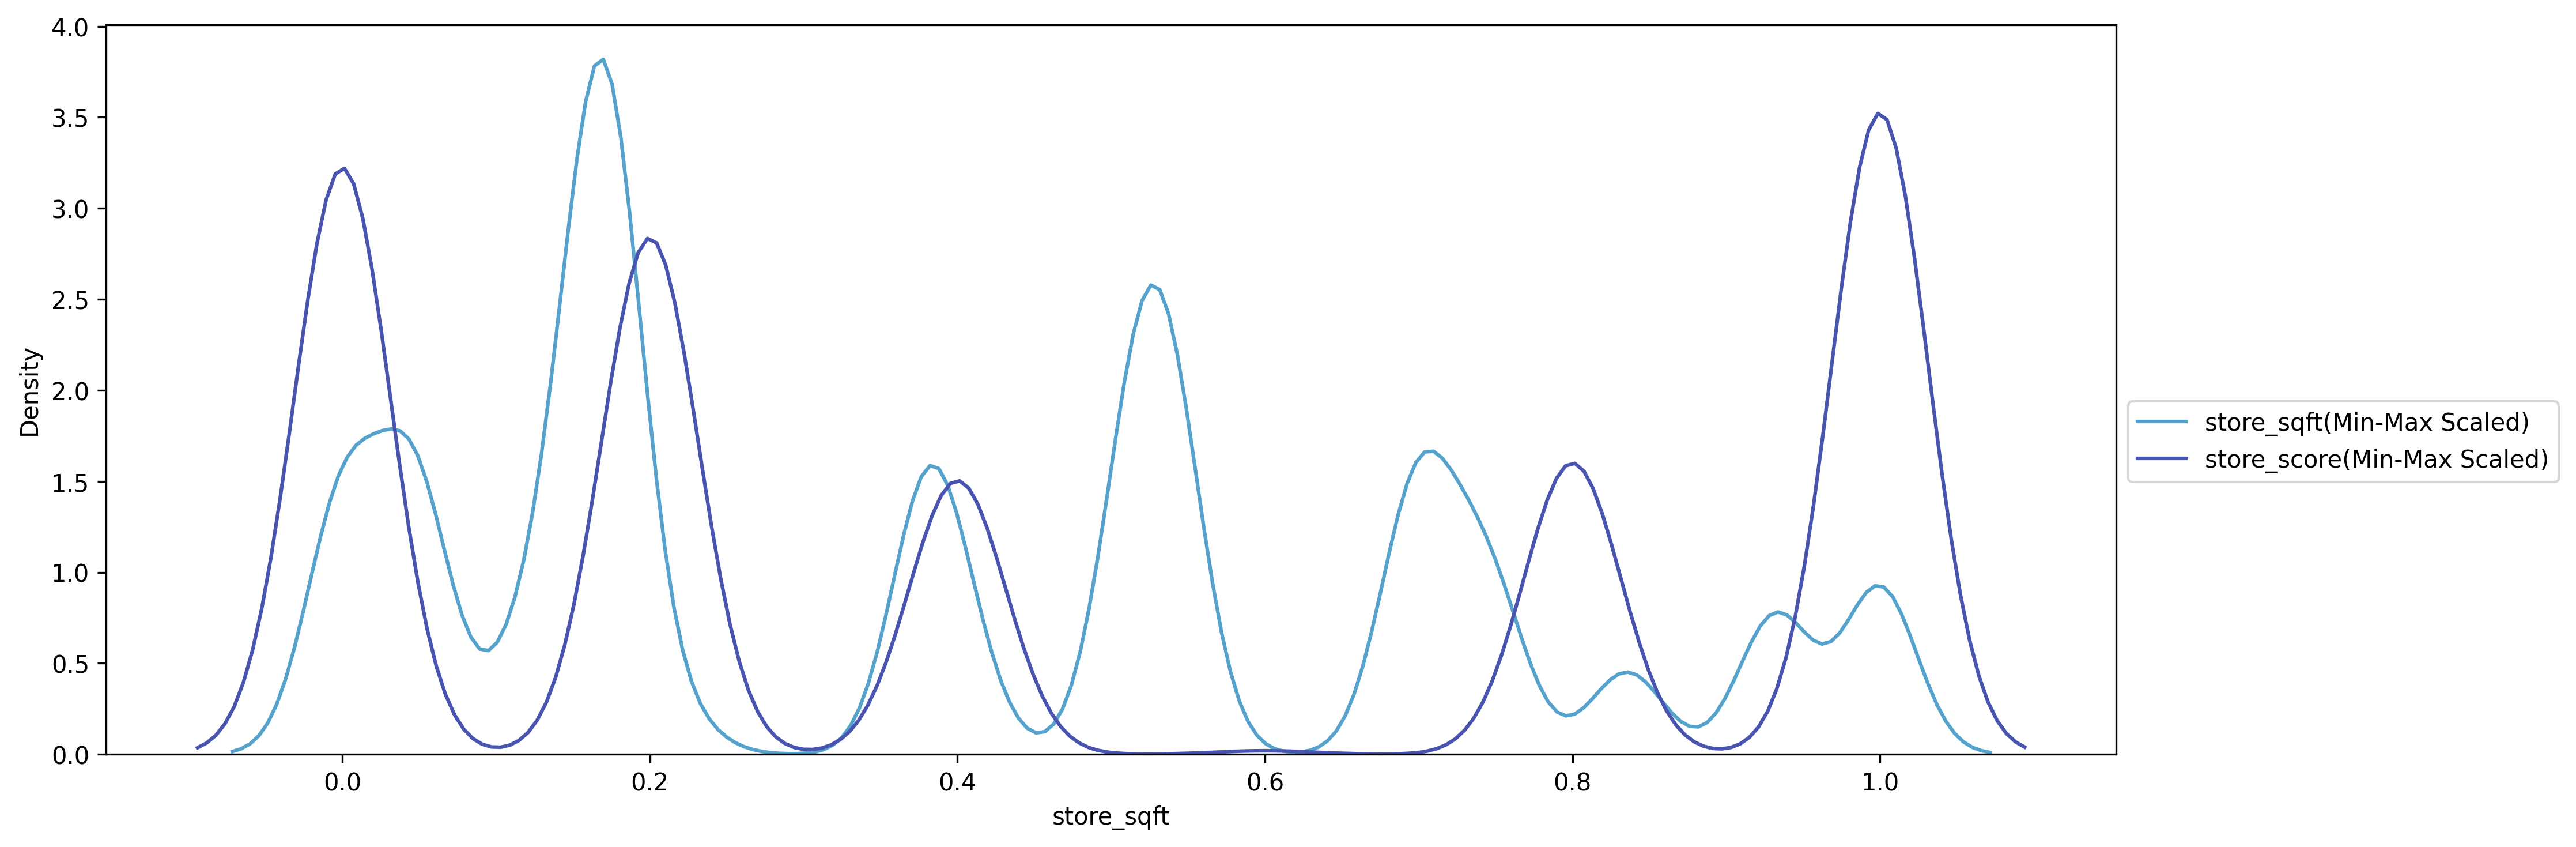

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 5), dpi=300)

store_features= ['coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
train['store_score'] = train[store_features].sum(axis=1)
test['store_score'] = test[store_features].sum(axis=1)

columns_to_plot = ['store_sqft', 'store_score']

scaler = MinMaxScaler()
train_scaled = train.copy()
train_scaled[columns_to_plot] = scaler.fit_transform(train_scaled[columns_to_plot])

for column, color in zip(columns_to_plot, palette):
    sns.kdeplot(data=train_scaled, x=column, ax=ax, color=color, label='Train')

fig.subplots_adjust(top=0.9)
ax.legend(labels=[f'{column}(Min-Max Scaled)' for column in columns_to_plot], loc='upper left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Basic feature engineering

### Minor warning issue

- Trouble occured when running lgbm
- Somehow lgbm didn't seem to filter the whitespace as other regressor models did

In [ ]:
'''
    - 가장 성능이 좋았던 lgbm, 그러나 모델학습시 minor warning이 발생한 부분은 바로 white space인 at과 home 사이
    - rename을 통해 under bar 생성
'''
train.rename(columns={'avg_cars_at home(approx).1': 'avg_cars_at_home(approx).1'}, inplace=True)
test.rename(columns={'avg_cars_at home(approx).1': 'avg_cars_at_home(approx).1'}, inplace=True)


### Constructed variable ['store_score']

In [ ]:
'''
    - CFM마트의 편의시설 5가지를 <원핫인코딩 처럼 활성화됨>을 강조하기 위해
      score처럼 관리하는 파생변수 'store_score' 생성
'''
store_features= ['coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']
train['store_score'] = train[store_features].sum(axis=1)
test['store_score'] = test[store_features].sum(axis=1)


### 99% of correlation between SALAD_BAR & PREPARED_FOOD
- another constructed variable ['prep_salad_food']

In [ ]:
'''
    - 히트맵을 통해 확인 할 수 있었던 1로 나타나는 두 독립변수간의 상관관계
    - 두 변수의 평균값을 구해 새로운 파생변수 생성
'''

train['prep_salad_food'] = train[['salad_bar', 'prepared_food']].mean(axis=1)

test['prep_salad_food'] = test[['salad_bar', 'prepared_food']].mean(axis=1)


### Inverting data type float ⇒ int

- to reduce the amount of computational time

In [ ]:
columns = ['total_children', 'num_children_at_home', 'recyclable_package', 'low_fat',
           'coffee_bar', 'video_store', 'salad_bar','prep_salad_food', 'salad_bar', 'florist','store_sqft','store_score']

for col in columns:
    print(train[col].unique())

[2. 4. 0. 5. 1. 3.]
[2. 0. 5. 1. 4. 3.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


KeyError: 'prep_salad_food'

In [ ]:
for col in columns:
    train[col] = train[col].astype('int64')
    test[col] = test[col].astype('int64')

NameError: name 'columns' is not defined

## Guideline of Lightgbm
- Which lead to accuire best score of $0.29346$

In [ ]:
'''
    - 1차 베이스라인 linear regressor 와 randomforestregressor를 통해 feature별 중요도 확인
    - 추가적인 시각화 자료를 통해 변별력이 없는 것과 파생변수로 만드는것을 진행
    - 최종적으로 선별된 feature만 lgbm을 통해 학습을 진행
'''
features = ['total_children', 'num_children_at_home', 'avg_cars_at_home(approx).1',
            'store_sqft', 'coffee_bar', 'video_store', 'florist','salad_bar','prep_salad_food','store_score']

In [ ]:
X = train[features]
y = train['cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((288268, 10), (72068, 10), (288268,), (72068,))

In [ ]:
def cus_rmsle(y_true,y_pred,transfer = True):
    '''
        - parameters
            - y_true   : 실제값
            - y_pred   : 예측값
            - transfer : True라면 이미 로그변환된 값으로보고 복원처리->
                         np.exp()
    '''
    # 원래 값의 범위로 복원
    if transfer:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    # 로그 변환 후 결측치의 0 값에 대한 보정
    # 평가함수 전에 데이터 변환으로 사용되는 함수를 log()로 사용한다는 전제
    log_y_true = np.nan_to_num(np.log1p(y_true))
    log_y_pred = np.nan_to_num(np.log1p(y_pred))

    # RMSLE 처리 진행
    return np.sqrt(np.mean((log_y_true - log_y_pred)**2))

In [ ]:
lgbm_model =LGBMRegressor()
y_train_log = np.log(y_train)
lgbm_model.fit(X_train,y_train_log)
y_pred = lgbm_model.predict(X_test)
print('lgbm rmsle value :',cus_rmsle(np.log(y_test),y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 288268, number of used features: 10
[LightGBM] [Info] Start training from score 4.552308
lgbm rmsle value : 0.2979938620955278


### 1st GridSearchCV

- The initial implementation was carried out using only a max_depth of 5 to minimize computation time

- Regarding the final search, it was determined that the optimal value was 6.

In [ ]:
import os
import sys


original_stdout = sys.stdout
original_stderr = sys.stderr

sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

lgbm_model =LGBMRegressor()

param_grid =    { 'max_depth': [5]}

# 그리드서치 수행
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring=make_scorer(cus_rmsle, greater_is_better=False), verbose=False)
grid_search.fit(X_train, y_train_log)

# Restore original stdout and stderr
sys.stdout = original_stdout
sys.stderr = original_stderr

# 최적의 하이퍼파라미터와 점수 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSLE found: ", -grid_search.best_score_)




Best parameters found:  {'max_depth': 5}
Best RMSLE found:  0.3000062592792362


### 2nd GridSearchCV
- The optimal parameter values discovered during the Bayesian optimization, Optuna, and AutoML processes
- After various attempts, the optimal parameter values were inputted to produce the final result.
- subsample,colsample_bytree values were just as important as depth,estimators,num_leaves

In [ ]:
original_stdout = sys.stdout
original_stderr = sys.stderr
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')


lgbm_model =LGBMRegressor()

param_grid =    { 'n_estimators': [2000],
    'max_depth': [6],
    'num_leaves': [100],
    'random_state' : [42],
    'subsample': [0.7],  # 각 트리를 학습할 때 사용되는 데이터 샘플의 비율
    'colsample_bytree': [0.68],  # 각 트리를 학습할 때 사용되는 피처의 비율

}


# GridSearchCV를 사용하여 수행
grid_search = GridSearchCV(lgbm_model, param_grid, cv=5, scoring=make_scorer(cus_rmsle, greater_is_better=False))
grid_search.fit(X_train, y_train_log)

sys.stdout = original_stdout
sys.stderr = original_stderr

#### Best params,RMSLE found

In [ ]:
skyblue = '\033[96m'  # Sky blue color
bold = '\033[1m'

print(skyblue + "Best parameters found: " + str(grid_search.best_params_))
print(skyblue + bold + "Best RMSLE found: " + str(-grid_search.best_score_))

Best parameters found: {'colsample_bytree': 0.68, 'max_depth': 6, 'n_estimators': 2000, 'num_leaves': 100, 'random_state': 42, 'subsample': 0.7}
Best RMSLE found: 0.29355824416793624


### Prediction with best_model

-
In order for prediction results to be measured accurately, the features in both the train and test sets should be identical

In [ ]:
best_model = grid_search.best_estimator_

# 테스트 데이터셋에 대한 예측 수행
test_preds = best_model.predict(test[['total_children', 'num_children_at_home', 'avg_cars_at_home(approx).1',
                                      'store_sqft', 'coffee_bar', 'video_store', 'florist','salad_bar','prep_salad_food','store_score']])

# 예측 결과를 원래 스케일로 변환하여 제출 파일에 저장
submission['cost'] = np.exp(test_preds)

# # 결과를 CSV 파일로 저장
# submission.to_csv('submission_lgbm_with_fe_v3.csv', index=False)

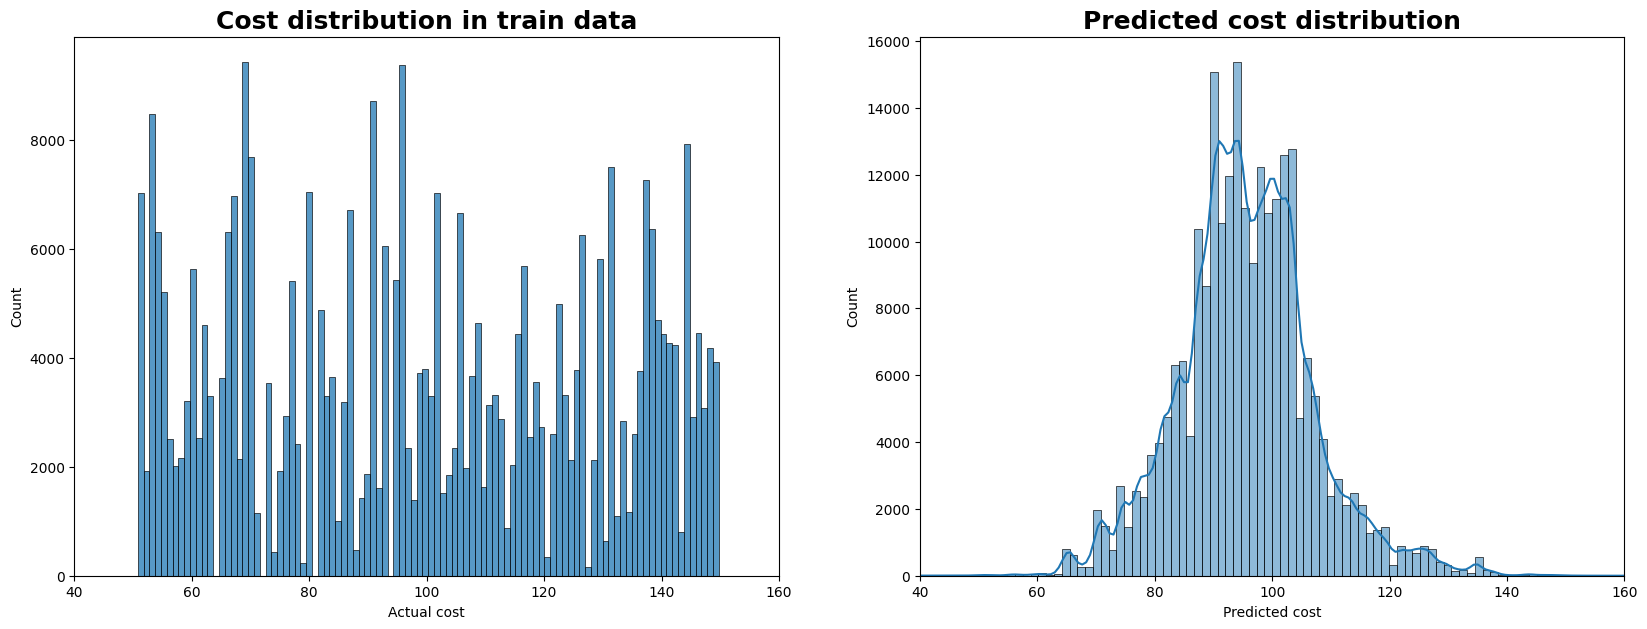

In [ ]:
# 기존 값과 예측결과값을 히스토그램으로 출력
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x='cost', bins=100)
plt.xlabel('Actual cost')
plt.title('Cost distribution in train data', fontsize=18, weight='bold')
plt.xlim(40, 160)

plt.subplot(1, 2, 2)
sns.histplot(data=submission, x='cost', bins=100, kde=True)
plt.xlabel('Predicted cost')
plt.title("Predicted cost distribution", fontsize=18, weight='bold')
plt.xlim(40, 160)

plt.show()
